<a href="https://colab.research.google.com/github/tsarouch/DS_tools_setup/blob/master/NLP07_Time_Series_Topic_Tracking_for_Airbnb_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Track topic change over time using the Python package BERTopic

# Resources

- [Blog post](https://medium.com/@AmyGrabNGoInfo/time-series-topic-tracking-for-airbnb-reviews-82ac1b30c0e3) for this tutorial
- Video version of the tutorial on [YouTube](https://www.youtube.com/watch?v=JGRshc6xatI&list=PLVppujud2yJpx5r8GFeJ81fyek8dEDMX-&index=7)
- More video tutorials on [NLP](https://www.youtube.com/playlist?list=PLVppujud2yJpx5r8GFeJ81fyek8dEDMX-)
- More blog posts on [NLP](https://medium.com/@AmyGrabNGoInfo/list/nlp-49340193610f)

For more information about data science and machine learning, please check out my [YouTube channel](https://www.youtube.com/channel/UCmbA7XB6Wb7bLwJw9ARPcYg), [Medium Page](https://medium.com/@AmyGrabNGoInfo) and [GrabNGoInfo.com](https://grabngoinfo.com/tutorials/), or follow GrabNGoInfo on [LinkedIn](https://www.linkedin.com/company/grabngoinfo/).

# Intro

Time series topic tracking can help us understand how the topics change over time for reviews or social media posts. In this tutorial, we will use Airbnb review data to illustrate the following:

* How to process the data to remove the noise in the topics?
* How to build a transformer-based topic model in Python?
* How to track the topic change over time?

The Python package used for the topic model in this tutorial is BERTopic. For more details about using this package, please check out my previous tutorials [Topic Modeling with Deep Learning Using Python BERTopic](https://medium.com/grabngoinfo/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504) and [Hyperparameter Tuning for BERTopic Model in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-for-bertopic-model-in-python-104445778347).

Let's get started!


# Step 1: Install And Import Python Libraries

In step 1, we will install and import python libraries.

Firstly, let's import `bertopic`.

In [ ]:
# Install bertopic
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 5.4 MB/s 
     |████████████████████████████████| 636 kB 17.9 MB/s 
     |████████████████████████████████| 85 kB 5.4 MB/s 
     |████████████████████████████████| 5.2 MB 44.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 7.5 MB/s 
     |████████████████████████████████| 5.5 MB 51.0 MB/s 
     |████████████████████████████████| 1.3 MB 49.3 MB/s 
     |████████████████████████████████| 163 kB 59.9 MB/s 
     |████████████████████████████████| 7.6 MB 42.3 MB/s 
     |████████████████████████████████| 1.1 MB 56.8 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp37-cp37m-linux_x86_64.whl size=2340702 sha256=ea0fcf0b563a6ce9f0089d4e856205c328b474cd1fdef815a2fd50926cfcad3c
  Stored in directory: /root/.cache

After installing the python packages, we will import the python libraries.
* `pandas` and `numpy` are imported for data processing.
* `seaborn` is for visualization.
* `nltk` is for removing stopwords.
* `UMAP` is for dimension reduction.
* `HDBSCAN` is for clustering models.
* `CountVectorizer` is for term vectorization.
* `BERTopic` is for the topic modeling.


In [ ]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns

# Text preprocessiong
import nltk
nltk.download('stopwords')

# Dimension reduction
from umap import UMAP

# Clustering
from hdbscan import HDBSCAN

# Count vectorization
from sklearn.feature_extraction.text import CountVectorizer

# Topic model
from bertopic import BERTopic

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Step 2: Download And Read Airbnb Review Data

The second step is to download and read the dataset.

A website called Inside Airbnb had the Airbnb data publicly available for research. We used the review data for Washington D.C. for this analysis, but the website provides other listing data from other locations around the world.

Please follow these steps to download the data.
1. Go to: http://insideairbnb.com/get-the-data
2. Scroll down the page until you see the section called **Washington, D.C., District of Columbia, United States**.
3. Click the blue file name "reviews.csv.gz" to download the review data.
4. Copy the downloaded file "reviews.csv.gz" to your project folder.

Note that Inside Airbnb generally provides quarterly data for the past 12 months, but users can make a [data request](http://insideairbnb.com/data-requests/) for historical data of a longer time range if needed.

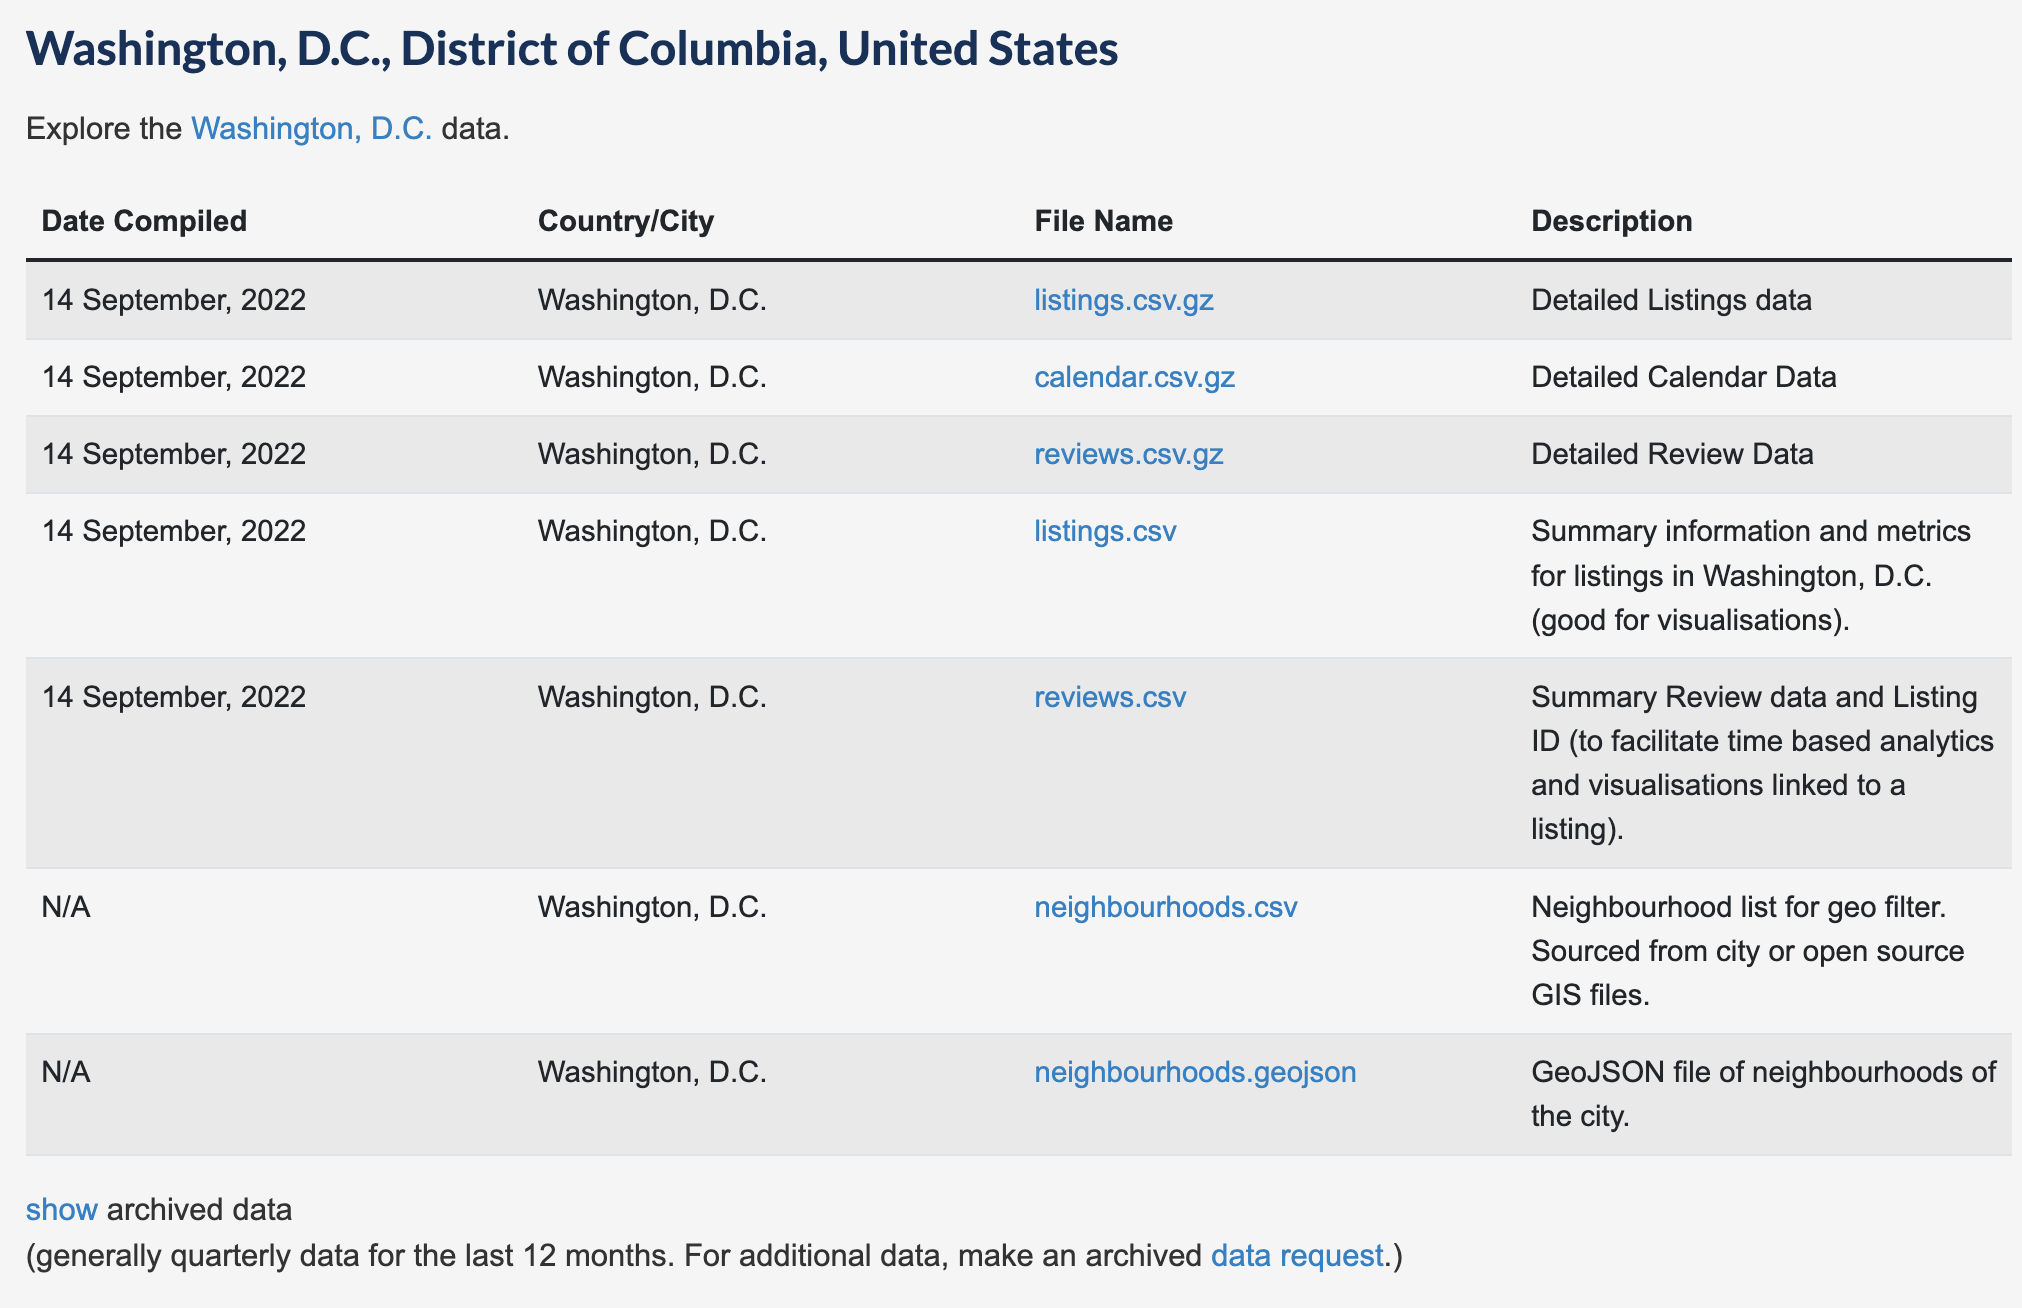

Those who are using Google Colab for this analysis need to mount Google Drive to read the dataset. You can ignore the code below if you are not using Google Colab.
* `drive.mount` is used to mount to the Google drive so the colab notebook can access the data on the Google drive.
* `os.chdir` is used to change the default directory on Google drive. I suggest setting the default directory to the project folder.
* `!pwd` is used to print the current working directory.

Please check out [Google Colab Tutorial for Beginners](https://medium.com/towards-artificial-intelligence/google-colab-tutorial-for-beginners-834595494d44) for details about using Google Colab for data science projects.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change directory
import os
os.chdir("drive/My Drive/contents/nlp")

# Print out the current directory
!pwd

Mounted at /content/drive
/content/drive/My Drive/contents/nlp


Now let's read the data into a `pandas` dataframe and see what the dataset looks like.

The dataset has multiple columns, but we only read the `comments` and `date` columns because the reviews and dates are the only information needed for this tutorial. The dataset has over three hundred thousand reviews, we read ten thousand reviews to make the computation manageable and save time for each iteration.

The `date` column is object type by default. We changed it to DateTime format using the `infer_datetime_format=True` argument.

In [ ]:
# Read in data
df = pd.read_csv('airbnb/airbnb_reviews_dc_20220914.csv.gz', nrows=10000, usecols=['comments', 'date'], compression='gzip')

# Change date to datetime format
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

# Take a look at the data
df.head()

,date,comments
0,2010-04-18,"Don's apartment is comfortable, clean and well..."
1,2010-06-10,Don was a great host. He went out of his way t...
2,2010-11-02,This place was great! Don was extremely helpfu...
3,2011-06-21,This condo was in a great location for touring...
4,2011-07-12,"The apartment was very clean, comfortable and ..."


`.info` helps us to get information about the dataset.

From the output, we can see that this data set has 10000 records and no missing data. The `comments` column is the `object` type and the `date` column is the `datetime64` type.

In [ ]:
# Get the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      10000 non-null  datetime64[ns]
 1   comments  10000 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 156.4+ KB


The time range for the Airbnb review dataset is January 20th, 2009 to September 14th, 2022.

In [ ]:
# Start date of the reviews
start_date = df['date'].min()

# Ending date of the reviews
end_date = df['date'].max()

# Time range
print(f'The time range for the review is {start_date} to {end_date}')

The time range for the review is 2009-01-20 00:00:00 to 2022-09-14 00:00:00


To examine the number of reviews by year, we extract the year information from the date column using `DatetimeIndex().year`, and save it as a separate column.

Airbnb was founded in August 2008. The `countplot` shows that there were very few reviews in 2009. The number increased over the years and became relatively stable from 2013 to 2019. There was a big drop in the number of reviews in 2020 due to COVID. Although the number of reviews are increasing since 2020, it is still much lower than the number before the pandemic.

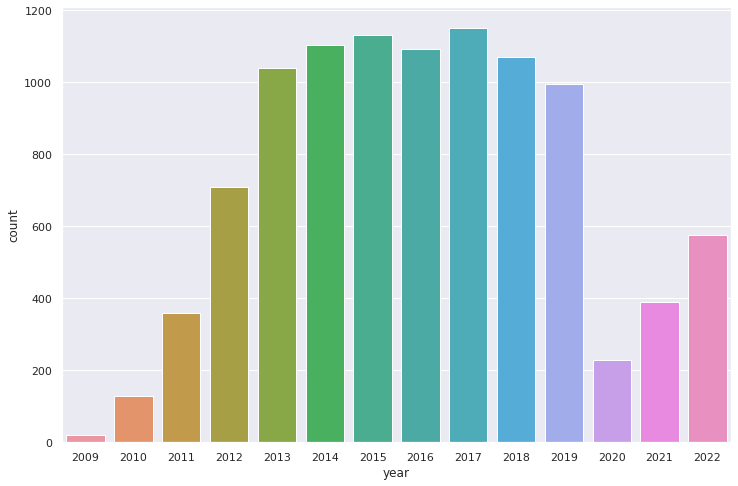

In [ ]:
# Create the year variable
df['year'] = pd.DatetimeIndex(df['date']).year

# Count plot
sns.set(rc={'figure.figsize':(12, 8)})
sns.countplot(df['year'])

# Step 3: Remove Noises from Topic Top Words

In step 3, we will remove the noises from the top words of the topic model.

There are three types of noises that impact the topic modeling results and interpretation, stop words, persons' names, and domain-specific words.

Stop words are the words that commonly appear in sentences but have no real meanings such as `the` and `for`. There are 179 stop words in the Python package NLTK.

In [ ]:
# NLTK English stopwords
stopwords = nltk.corpus.stopwords.words('english')

# Print out the NLTK default stopwords
print(f'There are {len(stopwords)} default stopwords. They are {stopwords}')

There are 179 default stopwords. They are ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'no

Persons' names are high-frequency words for Airbnb reviews because reviewers like to mention hosts' names in the review. Therefore, names are likely to become top words representing the topic, making interpreting the topics difficult.

To remove the hosts' names from the top keywords representing the topics, I downloaded the frequently occurring surname list from the [US Census Bureau](https://www.census.gov/topics/population/genealogy/data/2000_surnames.html). It contains the first names with a frequency of more than 100.
* There are two columns in the US Census Bureau surnames frequency dataset. We only read the column `name` because only name is needed for the tutorial.
* After reading the names into a pandas dataframe, they are transformed from upper cases to lower cases because the topic model uses lower cases.
* Two name lists are created using lowercase names, one list has the names, and the other has the name plus the letter `s`. This is because a lot of reviewers mention the host's apartment such as "Don's apartment". The word "Don's" becomes "Dons" after removing punctuation. So we need to remove the name plus the letter `s` from the top words as well.
* Each name list has 151,671 names and the top three names with the highest frequency are Smith, Johnson, and Williams.


In [ ]:
# Read in names
names = pd.read_csv('airbnb/surnames.csv', usecols=['name'])

# Host name list
name_list = names['name'].str.lower().tolist()

# Host's name list
names_list = list(map(( lambda x: str(x)+'s'), name_list))

# Print out the number of names
print(f'There are {len(name_list)} names in the surname list, and the top three names are {name_list[:3]}.')

There are 151671 names in the surname list, and the top three names are ['smith', 'johnson', 'williams'].


Domain-specific words are high-frequency words related to the business. For Airbnb reviews, reviewers frequently mention the word `airbnb`, `time`, `would`, and `stay`. Because I am using the data for Washington D.C., the word `dc` is a frequent word too.

In [ ]:
# Domain specific words to remove
airbnb_related_words = ['stay', 'airbnb', 'dc', 'would', 'time']

Removing noises is an iterative process, and we can add new words to the list if they do not provide valuable meanings and appear in the top topic words. For example, some less common names such as `natasha` can appear as top words. The word `also` appears in the top words too, but does not provide valuable information about the topic, so we will remove such words.

In [ ]:
# Other words to remove
other_words_to_remove = ['natasha', 'also', 'vladi']

To remove the noises from the top words representing the topics, we extended the stopwords with the name lists and the Airbnb-specific words. After the extension, 303,529 words are excluded from the top words.

In [ ]:
# Expand stopwords
stopwords.extend(name_list + names_list + airbnb_related_words + other_words_to_remove)
print(f'There are {len(stopwords)} stopwords.')

There are 303529 stopwords.


# Step 4: Build a Topic Model

In step 4, we will talk about how to build a topic model.

In this step, the time information is ignored and all the reviews are used to build the topic model. The output from the topic model will be used as the foundation for the time series analysis.

BERTopic model uses UMAP (Uniform Manifold Approximation & Projection) dimensionality reduction. BERTopic by default produces different results each time because of the stochasticity inherited from UMAP.

To get reproducible topics, we need to pass a value to the `random_state` parameter in the `UMAP` method.
* `n_neighbors=15` means that the local neighborhood size for UMAP is 15. This is the parameter that controls the local versus global structure in data.
 * A low value forces UMAP to focus more on local structure, and may lose insights into the big picture.
 * A high value pushes UMAP to look at the broader neighborhood, and may lose details on local structure.
 * The default `n_neighbors` value for UMAP is 15.
* `n_components=5` indicates that the target dimension from UMAP is 5. This is the dimension of data that will be passed into the clustering model.
* `min_dist` controls how tightly UMAP is allowed to pack points together. It's the minimum distance between points in the low-dimensional space.
 * Small values of `min_dist` result in clumpier embeddings, which is good for clustering. Since our goal of dimension reduction is to build clustering models, we set `min_dist` to 0.
 * Large values of `min_dist` prevent UMAP from packing points together and preserves the broad structure of data.
* `metric='cosine'` indicates that we will use cosine to measure the distance.
* `random_state` sets a random seed to make the UMAP results reproducible.

`CountVectorizer` is for counting the words frequency. Passing the extended stop words list helps us to remove noises from the top words representing each topic.

In [ ]:
# Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)

# Count vectorizer
vectorizer_model = CountVectorizer(stop_words=stopwords)

In the BERTopic function, we tuned a few hyperparameters. To learn more about hyperparameter tuning, Please check out my previous tutorial [Hyperparameter Tuning for BERTopic Model in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-for-bertopic-model-in-python-104445778347).

* `umap_model` takes the model for dimensionality reduction. We are using the UMAP model for this tutorial, but it can be other dimensionality reduction models such as PCA (Principle Component Analysis).
* `vectorizer_model` takes the term vectorization model. The extended stop words list is passed into the BERTopic model through `CountVectorizer`.
* `diversity` helps to remove the words with the same or similar meanings. It has a range of 0 to 1, where 0 means least diversity and 1 means most diversity.
* `min_topic_size` is the minimum number of documents in a topic. `min_topic_size=200` means that a topic needs to have at least 200 reviews.
* `top_n_words=4` indicates that we will use the top 4 words to represent the topic.
* `language` has English as the default. We set it to `multilingual` because there are multiple languages in the Airbnb reviews.
* `calculate_probabilities=True` means that the probabilities of each document belonging to each topic are calculated. The topic with the highest probability is the predicted topic for a new document. This probability represents how confident we are about finding the topic in the document.

In [ ]:
# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model,
                       vectorizer_model=vectorizer_model,
                       diversity=0.8,
                       min_topic_size=200,
                       top_n_words=4,
                       language="multilingual",
                       calculate_probabilities=True)

# Run BERTopic model
topics = topic_model.fit_transform(df['comments'])

# Get the list of topics
topic_model.get_topic_info()

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

,Topic,Count,Name
0,-1,2442,-1_recommend_restaurants_stayed_bed
1,0,4564,0_clean_neighborhood_restaurants_bed
2,1,515,1_breakfast_neighborhood_recommend_feel
3,2,513,2_bike_bed_neighbourhood_efficiency
4,3,487,3_comfortable_meet_neighborhood_subway
5,4,447,4_cathedral_recommend_basement_feel
6,5,282,5_comfortable_breakfast_tv_organic
7,6,280,6_apartment_recommend_bathroom_feel
8,7,242,7_great_neighborhood_restaurants_comfortable
9,8,228,8_stadium_parking_staying_bathroom


Using the attribute `get_topic_info()` on the topic model gives us a list of topics. We can see that the output gives us 9 rows in total.

* Topic -1 should be ignored. It indicates that the reviews are not assigned to any specific topic. The count for topic -1 is 2442, meaning that there are 2442 outlier reviews that do not belong to any topic.
* Topic 0 to topic 8 are the 9 topics created for the reviews. It was ordered by the number of reviews in each topic, so topic 0 has the highest number of reviews.
* The Name column lists the top terms for each topic. For example, the top 4 terms for Topic 0 are clean, neighborhood, restaurants, and bed, indicating that it is a topic related to a convenient neighborhood.


# Step 5: Topics Over Time

In step 5, we will talk about how to generate topic representations for each topic over time.

The Python BERTopic package calculates topics' evolution over time based on the topic model output. The class-based TF-IDF will be calculated for each topic and timestamp combination. There is no need to rerun the topic model multiple times to create clusters from embeddings for each timestamp.

To get the topic representations over time, we can apply the `topics_over_time` function on the topic model and pass in the reviews and dates.
* `global_tuning=True` indicates that the topic representation at a certain timestamp is averaged with the global representation of the topic. This helps to increase the similarity between the time-specific topic representation and the overall topic representation.
* `evolution_tuning=True` indicates that the c-TF-IDF at time t is averaged with the c-TF-IDF at time t-1. This moving average step allows a stable evolution of topic representation over time.
* Both `global_tuning` and `evolution_tuning` have the default value of `True`, but we can change it to `False` if we do not want the topic representation influenced by the global topic or the previous timestamp.
* `nr_bins` controls the number of unique timestamps. BERTopic suggests keeping this number below 50. `nr_bins=13` means that there will be 13 equal-sized bins for the time.









In [ ]:
# Topics over time
topics_over_time = topic_model.topics_over_time(df['comments'],
                                                df['date'],
                                                global_tuning=True,
                                                evolution_tuning=True,
                                                nr_bins=13)

# Take a look at the data
topics_over_time.head()

,Topic,Words,Frequency,Timestamp
0,-1,"feeder, greyhound, minutes, apartment",7,2009-01-15 00:21:36.000000000
1,0,"grandparents, grocery, maps, upstairs",3,2009-01-15 00:21:36.000000000
2,3,"subway, drip, whirlwind, thoughtfulness",10,2009-01-15 00:21:36.000000000
3,4,"allergies, playground, knowledgeable, hotels",2,2009-01-15 00:21:36.000000000
4,-1,"restaurants, staying, parking, bugs",39,2010-02-07 11:04:36.923076864


The output of `topics_over_time` is saved in a pandas dataframe. The dataframe has four columns.
* The column `Topic` has the topic number from the topic model.
* The column `Words` has the top word representation for the topic at the specific timestamp bin.
* The column `Frequency` has the number of reviews for the topic in the specific timestamp bin.
* The column `Timestamp` has the timestamp cutoff points for the bins.

# Step 6: Time Series Topic Tracking Visualization

In step 6, we will talk about how to visualize the topics over time.

The `visualize_topics_over_time` function takes in the `topics_over_time` dataframe and produces the time series graph for topic changes over time.

We can use `top_n_topics` to limit the number of topics to show in the time series graph.

From the topics over time visualization, we can see that
* Topic 0 consistently has the highest review volume since 2010 compared with other topics. Other topics have similar review volumes.
* Topic 0 has an upward trend over time before the pandemic, while topic 3 and topic 4 have downward trend since 2012.
* Hovering over the timestamp cutoff points shows the topic representation for the topic at that specific timestamp bin. We can see that reviews in topic 0 talk about parking a lot from 2012 to 2015, and parking was not a hot topic anymore between 2016 to 2019. People care more about neighborhoods and restaurants over time.
* The legends under the "Global Topic Representation" are clickable. Clicking the legend turns the line on the chart on and off.


In [ ]:
# Visualize topic over time
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)

If the time series comparison of two or more topics, we can list the topic number in the `topics` argument. For example, after passing in `topics=[1, 2]`, only topics 1 and topic 2 are plotted.

In [ ]:
# Visualize specific topics
topic_model.visualize_topics_over_time(topics_over_time, topics=[1, 2])

# Recommended Tutorials

- [GrabNGoInfo Machine Learning Tutorials Inventory](https://medium.com/grabngoinfo/grabngoinfo-machine-learning-tutorials-inventory-9b9d78ebdd67)
- [Hierarchical Topic Model for Airbnb Reviews](https://medium.com/p/hierarchical-topic-model-for-airbnb-reviews-f772eaa30434)
- [3 Ways for Multiple Time Series Forecasting Using Prophet in Python](https://medium.com/p/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python-7a0709a117f9)
- [Time Series Anomaly Detection Using Prophet in Python](https://medium.com/grabngoinfo/time-series-anomaly-detection-using-prophet-in-python-877d2b7b14b4)
- [Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/time-series-causal-impact-analysis-in-python-63eacb1df5cc)
- [Hyperparameter Tuning For XGBoost](https://medium.com/p/hyperparameter-tuning-for-xgboost-91449869c57e)
- [Four Oversampling And Under-Sampling Methods For Imbalanced Classification Using Python](https://medium.com/p/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037)
- [Five Ways To Create Tables In Databricks](https://medium.com/grabngoinfo/five-ways-to-create-tables-in-databricks-cd3847cfc3aa)
- [Explainable S-Learner Uplift Model Using Python Package CausalML](https://medium.com/grabngoinfo/explainable-s-learner-uplift-model-using-python-package-causalml-a3c2bed3497c)
- [One-Class SVM For Anomaly Detection](https://medium.com/p/one-class-svm-for-anomaly-detection-6c97fdd6d8af)
- [Recommendation System: Item-Based Collaborative Filtering](https://medium.com/grabngoinfo/recommendation-system-item-based-collaborative-filtering-f5078504996a)
- [Hyperparameter Tuning for Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-for-time-series-causal-impact-analysis-in-python-c8f7246c4d22)
- [Hyperparameter Tuning and Regularization for Time Series Model Using Prophet in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc)
- [Multivariate Time Series Forecasting with Seasonality and Holiday Effect Using Prophet in Python](https://medium.com/p/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57)
- [LASSO (L1) Vs Ridge (L2) Vs Elastic Net Regularization For Classification Model](https://medium.com/towards-artificial-intelligence/lasso-l1-vs-ridge-l2-vs-elastic-net-regularization-for-classification-model-409c3d86f6e9)
- [S Learner Uplift Model for Individual Treatment Effect and Customer Segmentation in Python](https://medium.com/grabngoinfo/s-learner-uplift-model-for-individual-treatment-effect-and-customer-segmentation-in-python-9d410746e122)
- [How to Use R with Google Colab Notebook](https://medium.com/p/how-to-use-r-with-google-colab-notebook-610c3a2f0eab)

# References

* [BERTopic GitHub](https://github.com/MaartenGr/BERTopic)
* [Documentation on BERTopic dynamic topic modeling](https://maartengr.github.io/BERTopic/getting_started/topicsovertime/topicsovertime.html)
* [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/parameters.html)
* [US Census Bureau frequently occurring surnames](https://www.census.gov/topics/population/genealogy/data/2000_surnames.html)
* [CountVectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)